In [1]:
from functools import partial

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sympy as sy
import y0
from sklearn.metrics import r2_score
from y0.dsl import Variable
from y0.graph import NxMixedGraph

from nocap import scm, utility

np.random.seed(42)
#!pip install pgmpy

## load e. coli network

In [2]:
ecoli_filepath = "./ecoli/ecoli_full_network_no_small_rna.graphml"
ecoli_network = nx.read_graphml(ecoli_filepath)

## get fadR subnetwork

In [3]:
# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(directed=fadr_graph_dag.edges)

print(f"{len(fadr_graph_mixed.directed.nodes)} nodes")
print(f"{len(fadr_graph_mixed.directed.edges)} edges")

109 nodes
437 edges


## simulate data for fadR subnetwork using linear model

In [4]:
# fadr_node_generators = {
#     node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
# }
# fadr_edge_weights = {
#     edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_node_generators = {
    node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
}
# fadr_edge_weights = {
#     edge: np.random.uniform(low=-1, high=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_edge_weights = {
    edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
}

n_samples = 10000

fadr_df_lscm = scm.simulate_lscm(
    graph=fadr_graph_mixed,
    node_generators=fadr_node_generators,
    edge_weights=fadr_edge_weights,
    n_samples=n_samples,
)

print(fadr_df_lscm.head())

       basR     c0293      btsR      glaR      fabR      cpxR      nsrR  \
0 -1.380101 -1.703382 -0.055548  0.384065 -0.032695 -2.067442 -0.089120   
1  0.577072 -0.203045  0.371146 -0.603985  0.086590 -0.155677  1.167782   
2  0.059218  0.013929 -0.024125  0.198085 -0.144360 -0.573662 -0.546859   
3  1.149273 -0.703176 -0.034988  1.770801 -0.626967  1.812449  0.707752   
4 -0.730930 -0.033127  1.794558 -0.517611  0.223788 -0.016423  1.188393   

       dksA      lexA      ptrR  ...       fadL       marR      csgD  \
0 -1.304470  0.669673  0.366598  ... -47.128806 -23.688049  7.103111   
1  0.254421  0.337603 -0.411877  ...  22.499637   8.059951  6.927537   
2 -0.032753 -0.543425 -0.712846  ... -74.324538 -38.568650  1.267232   
3 -0.562467  0.632408  0.972554  ...  18.036727   7.498591 -6.055807   
4  2.526932 -0.530869 -0.489439  ...  64.206841  36.977291 -7.828650   

        flhC       flhD       marA       iclR       aceA       aceB       aceK  
0  26.493412  26.223695  44.838600 

## calibrate linear fadR model to data

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_47185/2912437397.py:1: UserWarning: Correlation matrix contains 1 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 3.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_47185/2912437397.py:1: UserWarning: Correlation matrix contains 1 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 3.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_47185/2912437397.py:1: UserWarning: Correlation matrix contains 1 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 3.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cw

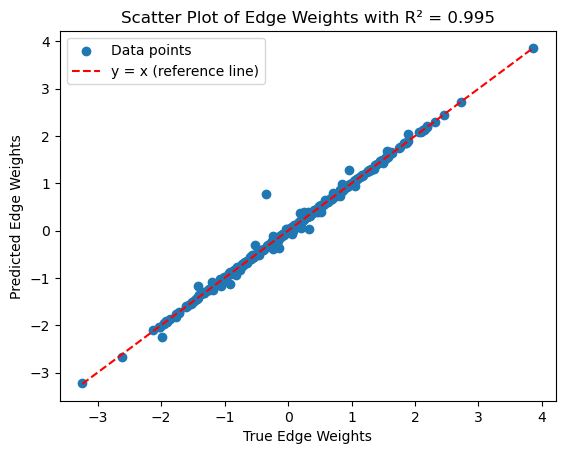

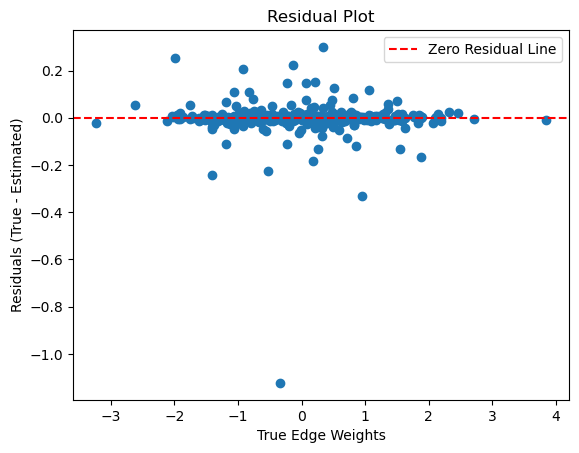

In [5]:
fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)


def plot_scatter_with_r2(exp_edges, pred_edges):
    exp_values = np.array([exp_edges[edge] for edge in exp_edges])
    pred_values = np.array([pred_edges[edge] for edge in pred_edges])

    # Calculate R^2 value
    r2 = r2_score(exp_values, pred_values)

    # Create scatter plot
    plt.scatter(exp_values, pred_values, label="Data points")
    max_val = max(np.max(exp_values), np.max(pred_values))
    min_val = min(np.min(exp_values), np.min(pred_values))
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Predicted Edge Weights")
    plt.title(f"Scatter Plot of Edge Weights with R² = {r2:.3f}")
    plt.legend()
    plt.show()


def plot_residuals(true_weights, estimated_weights):
    true_values = np.array([value for value in true_weights.values()])
    estimated_values = np.array([value for value in estimated_weights.values()])

    # Calculate residuals
    residuals = true_values - estimated_values

    # Scatter plot of residuals
    plt.scatter(true_values, residuals)
    plt.axhline(0, color="r", linestyle="--", label="Zero Residual Line")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Residuals (True - Estimated)")
    plt.title("Residual Plot")
    plt.legend()
    plt.show()


# Example usage
plot_scatter_with_r2(fadr_edge_weights, fadr_edge_weight_estimates)

plot_residuals(fadr_edge_weights, fadr_edge_weight_estimates)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  4.,  4.,  4.,
         5.,  7.,  7.,  6.,  5.,  8.,  9., 11., 11., 10.,  7., 11., 17.,
         6.,  9., 11., 12., 10., 10., 13., 19., 13.,  9., 14., 18.,  9.,
        11.,  8., 13., 11., 11., 11.,  7.,  7.,  6.,  5.,  4.,  7.,  1.,
         4.,  7.,  4.,  2.,  2.,  2.,  4.,  1.,  0.,  2.,  5.,  2.,  1.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3.22096741, -3.15013363, -3.07929986, -3.00846608, -2.93763231,
        -2.86679853, -2.79596476, -2.72513098, -2.65429721, -2.58346343,
        -2.51262966, -2.44179588, -2.37096211, -2.30012833, -2.22929455,
        -2.15846078, -2.087627  , -2.01679323, -1.94595945, -1.87512568,
        -1.8042919 , -1.73345813, -1.66262435, -1.59179058, -1.5209568 ,
        -1.45012303, -1.37928925, -1.30845547, -1.2376217 , -1.166787

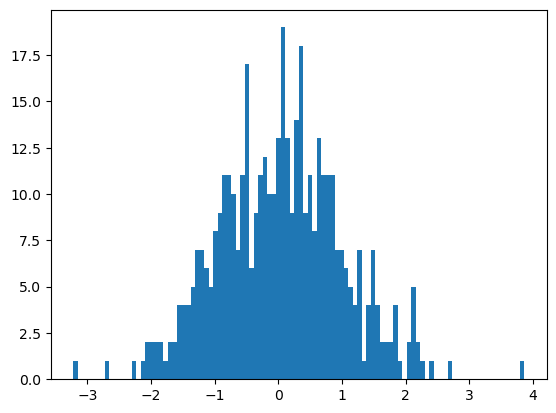

In [6]:
fadr_edge_weight_values = np.array([value for value in fadr_edge_weights.values()])
fadr_edge_weight_values_predicted = np.array(
    [value for value in fadr_edge_weight_estimates.values()]
)

#plt.hist(fadr_edge_weight_values, bins=100)
plt.hist(fadr_edge_weight_values_predicted, bins=100)

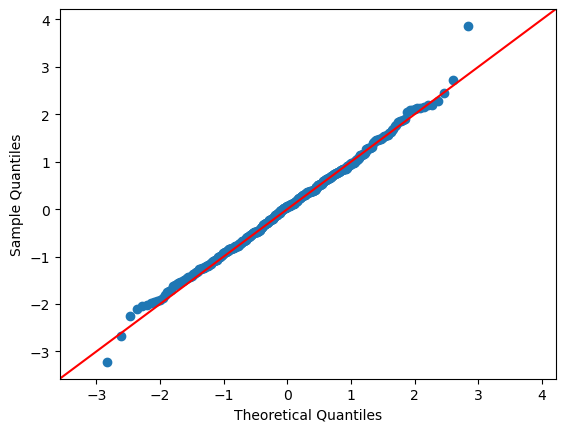

In [7]:
import numpy as np
import pylab as py
import statsmodels.api as sm

# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code
# the graph look different than shown below.

# Random data points generated
data_points = np.array([v for v in fadr_edge_weight_estimates.values()])

# fadr_edge_weight_estimates

sm.qqplot(data_points, line="45")
py.show()

## perform intervention on fadR subnetwork and simulate interventional data from calibrated model

In [8]:
fadr_intervened_lscm_calibrated = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weight_estimates,
)

fadr_df_lscm_calibrated_intervened = pd.DataFrame(
    {
        trial: {
            variable.name: values
            for variable, values in fadr_intervened_lscm_calibrated.trial().items()
        }
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_calibrated_intervened.head())

       basR     c0293  fadR      btsR      glaR      fabR      cpxR      nsrR  \
0 -1.088574 -0.084086  10.0 -1.225524 -0.253118 -1.904703  1.744087 -0.822342   
1  0.369077 -1.035565  10.0 -0.456639  0.198233  0.744524  0.118041 -0.750188   
2  1.065892  0.971019  10.0  0.531157 -0.446999  1.051504 -1.282194  2.511619   
3 -0.034516 -0.618404  10.0  0.432301 -0.466407 -0.041468  0.478305  1.029340   
4 -1.360637  1.994048  10.0  0.558910 -0.759699 -0.191055  1.531902 -1.179717   

       dksA      lexA  ...       fadL       marR       csgD       flhC  \
0  0.103354 -0.234237  ... -12.183349  -8.749442  -6.957300  14.749204   
1  0.257439  1.838653  ...  13.867739  11.697630   8.304895   2.836978   
2  0.523905 -0.947238  ... -30.401510  -8.864409   7.529409  -2.869351   
3 -1.607704 -0.069824  ...  48.600616  26.090242  -0.675019  -3.485664   
4  0.624253 -0.564768  ... -62.957188 -36.692620 -21.197778  30.592769   

        flhD       marA       iclR       aceA       aceB       aceK 

## perform intervention on fadR subnetwork and simulate interventional data from actual model

In [9]:
fadr_intervened_lscm = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weights,
)

fadr_df_lscm_intervened = pd.DataFrame(
    {
        trial: {variable.name: values for variable, values in fadr_intervened_lscm.trial().items()}
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_intervened.head())

       basR     c0293  fadR      btsR      glaR      fabR      cpxR      nsrR  \
0  0.323814  0.317904  10.0 -1.380135  0.718863  2.020001 -0.591883  0.636196   
1  0.757707 -0.674238  10.0 -1.249498  0.749757 -0.522308  0.170877 -0.465833   
2 -0.341650  0.097788  10.0 -0.311928  1.048295 -0.215257 -0.333588  0.465659   
3  1.751816  1.946272  10.0 -0.559436 -0.846651  1.346772 -0.131846  0.695677   
4  0.980227 -0.739102  10.0  0.002356  0.535894  0.622148  0.458859  0.615337   

       dksA      lexA  ...       fadL       marR      csgD       flhC  \
0 -1.132677  1.050044  ... -16.511165  -6.900203 -1.894324   3.785306   
1 -0.025226  0.069478  ...  -0.177652  -3.047774  9.269707  14.013123   
2  0.934905 -0.251603  ...  81.652016  39.755820  1.461705 -53.967350   
3  0.003300  0.390280  ... -20.427423  -8.665338  5.814807  11.917205   
4 -2.973769  0.142422  ... -47.973714 -25.095148  8.614816  19.214722   

        flhD       marA       iclR       aceA        aceB       aceK  
0  

## calculate expected and predicted average treatment effect of fadR linear model

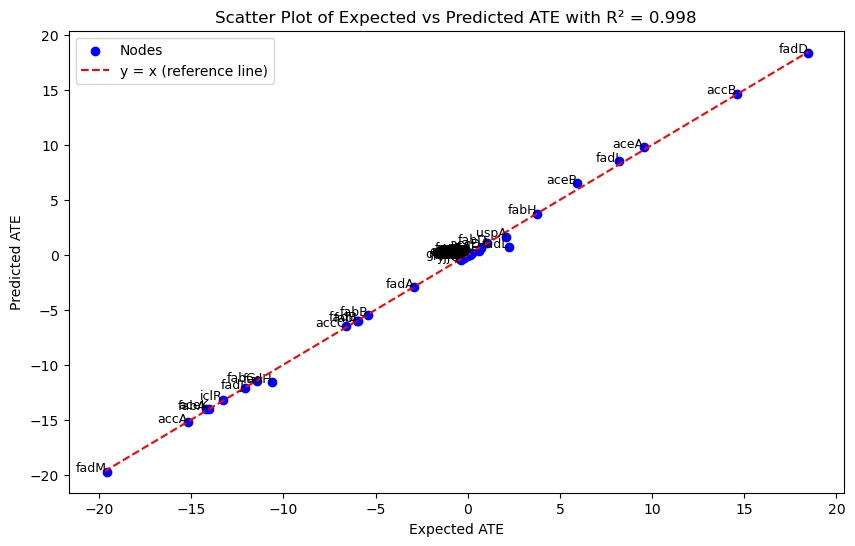

In [10]:
targets_list = [
    node for node in fadr_graph_mixed.nodes() if node.name != "fadR"
]  # all nodes except intervened node 'fadR'


expected_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_intervened, targets_list
)
predicted_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_calibrated_intervened, targets_list
)

# print(f"expected ATE:{expected_fadr_ATE}")
# print(f"actual ATE:{predicted_fadr_ATE}")


# Extract values in the same order
expected_values = np.array([expected_fadr_ATE[node] for node in expected_fadr_ATE])
predicted_values = np.array([predicted_fadr_ATE[node] for node in predicted_fadr_ATE])

# Calculate R2 value
r2 = r2_score(expected_values, predicted_values)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(expected_values, predicted_values, color="blue", label="Nodes")

# Add node labels
for i, node in enumerate(expected_fadr_ATE.keys()):
    plt.text(expected_values[i], predicted_values[i], node, fontsize=9, ha="right")

# Reference line (y=x)
max_val = max(np.max(expected_values), np.max(predicted_values))
min_val = min(np.min(expected_values), np.min(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")

# Add labels and title
plt.xlabel("Expected ATE")
plt.ylabel("Predicted ATE")
plt.title(f"Scatter Plot of Expected vs Predicted ATE with R² = {r2:.3f}")
plt.legend()

plt.show()

## Non-linear data generation using SERGIO (modified Hill equation)

In [11]:
import sys

sys.path.append("/Users/geor228/Github/SERGIO")  # TODO: fix this
from SERGIO import gene, sergio

### SERGIO wrapper functions and test

In [13]:
def simulate_SERGIO(number_genes, number_bins, targets_file, regs_file, mapping, number_sc=100):
    """Simulate SERGIO and return gene expression dataframes clean and also with technical noise added."""
    sim = sergio.sergio(
        number_genes,
        number_bins,
        number_sc=number_sc,
        noise_params=1,
        noise_type="dpd",
        decays=0.8,
        sampling_state=15,
    )
    sim.build_graph(input_file_taregts=targets_file, input_file_regs=regs_file, shared_coop_state=0)
    sim.simulate()
    expr = sim.getExpressions()

    # get clean expression (steady state) dataframe
    expr_clean_ss = np.concatenate(expr, axis=1)
    df_output = pd.DataFrame(expr_clean_ss)
    gene_mapping = df_output.index.map(mapping)
    df_output.insert(0, "gene", gene_mapping)
    
    # get expression w/ technical noise dataframe
    # outlier
    expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 0.8, scale = 1)
    # library size
    libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.6, scale = 0.4)
    # dropout
    binary_ind = sim.dropout_indicator(expr_O_L, shape = 6.5, percentile = 82)
    expr_O_L_D = np.multiply(binary_ind, expr_O_L)
    # UMI
    count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)
    count_matrix = np.concatenate(count_matrix, axis = 1)
    df_output_noise = pd.DataFrame(count_matrix)
    #print(df_output_noise)
    df_output_noise.insert(0, "gene", gene_mapping)

    assert not df_output.equals(df_output_noise), "DataFrames should not be equal."
  
    return df_output, df_output_noise


def generate_sergio_data(
    target_gene,
    gene_network,
    base_param_distributions,
    n_replicas,
    targets_filename,
    regs_filename,
    seed,
    draw_network_layout=True,
    network_filename=None,
    data_filename=None,
    sergio_clean_outname="sergio_data_clean.csv",
    sergio_noise_outname="sergio_data_noise.csv",
    number_sc = 10
):

    input_nodes = set(gene_network.nodes)
    # Set the random seed
    #np.random.seed(seed)

    # Get subgraph for the target gene if it's not already a DAG
    if not nx.is_directed_acyclic_graph(gene_network):
        network_all = utility.get_subgraph_from_nodes(gene_network, [target_gene], descendants_only=False)
        network_dag = utility.convert_to_acyclic_graph(network_all, target_gene)
    else:
        network_dag = gene_network

    assert set(network_dag.nodes) == input_nodes, "input network nodes are not equal to the processed network nodes"

    # Optionally draw the network
    if draw_network_layout:
        utility.draw_network(network_dag)
    # Optionally save the network to a file
    if network_filename is not None:
        nx.write_gml(network_dag, f"{network_filename}")

    # Define distribution settings for the parameters
    param_distributions = base_param_distributions.copy()
    master_regulators = [node for node, indegree in network_dag.in_degree() if indegree == 0]

    for replica_id, param_dist in param_distributions.items():
        param_dist["master_regulators"]= master_regulators

    #param_distributions["master_regulators"] = master_regulators

    # Generate hill equations and random parameter values from distribution
    all_replica_equations = utility.generate_hill_equations_for_n_replicas(
        network_dag, activation_probability=0.5, n=n_replicas, seed=seed
    )
    all_parameter_values = utility.assign_random_values_for_n_replicas(
        all_replica_equations, param_distributions, seed=seed
    )
    #print("All parameter values dict:", all_parameter_values)

    if data_filename is not None:
        utility.write_equation_info_to_file(all_replica_equations, all_parameter_values, data_filename)

    # Convert to SERGIO compatible data and save to file
    node_to_idx = utility.create_node_to_idx_mapping(network_dag)
    print(node_to_idx)
    assert set(node_to_idx.keys()) == input_nodes, "input network nodes are not equal to the node to index keys"
    idx_to_node = {v: k for k, v in node_to_idx.items()}
    print(idx_to_node)
    # Adjust the keys in all_parameter_values to start from 1 if necessary
    all_targets_dfs, all_regs_dfs = utility.create_dataframes_for_sergio_inputs_from_n_replicas(
        network_dag, all_parameter_values, node_to_idx,
    )
    targets_df, regs_df = utility.merge_n_replica_dataframes_for_sergio_inputs(
        all_targets_dfs, all_regs_dfs, merge_type="first_only"
    )
    utility.write_input_files_for_sergio(targets_df, regs_df, targets_filename, regs_filename)
    mapping = idx_to_node
    # Validate SERGIO inputs
    df_clean, df_noise = simulate_SERGIO(number_genes=len(network_dag.nodes()),
                    number_bins=n_replicas,
                    targets_file=targets_filename,
                    regs_file=regs_filename,
                    mapping=mapping, 
                    number_sc=number_sc)
    df_clean.to_csv(sergio_clean_outname)
    df_noise.to_csv(sergio_noise_outname)

    return df_clean, df_noise


# Test case function
def test_generate_sergio_data():
    # Create a basic directed graph with a single self-loop and a cycle
    gene_network = nx.DiGraph()
    gene_network.add_edge("Gene1", "Gene1", polarity="+")  # Self-loop
    gene_network.add_edge("Gene1", "Gene2", polarity="-")
    gene_network.add_edge("Gene2", "Gene3", polarity="+/-")
    gene_network.add_edge("Gene3", "Gene1", polarity="")  # Cycle

    # Define base parameter distributions (mock dictionary)
    base_param_distributions1 = {
        "K": {"min": 1, "max": 5},
        "n": {"min": 1, "max": 3},
        "h": {"min": 1, "max": 5},
        "b": {"a": 2, "b": 5, "scale": 4},
    }
    base_param_distributions2 = {
        "K": {"min": 1, "max": 5},
        "n": {"min": 1, "max": 3},
        "h": {"min": 1, "max": 5},
        "b": {"a": 2, "b": 5, "scale": 40},
    }

    base_param_distributions = {
        0: base_param_distributions1,
        1: base_param_distributions2
    }

    # Call the generate_sergio_data function with the test graph and parameters
    generate_sergio_data(
        target_gene="Gene1",
        gene_network=gene_network,
        base_param_distributions=base_param_distributions,
        n_replicas=2,
        targets_filename="test_targets_2_bins.csv",
        regs_filename="test_regs_2_bins.csv",
        seed=[42,43],
        draw_network_layout=False,  # Disable drawing for the test
        network_filename="test_graph_2_bins.graphml",
        data_filename="test_eqns_and_params_2_bins.txt",
        sergio_clean_outname="test_sergio_data_clean.csv",
        sergio_noise_outname="test_sergio_data_noise.csv",
        number_sc = 10
    )

    print("Test passed for generate_sergio_data.")


# Run the test case function
test_generate_sergio_data()


{'Gene1': 0, 'Gene2': 1, 'Gene3': 2}
{0: 'Gene1', 1: 'Gene2', 2: 'Gene3'}
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Test passed for generate_sergio_data.


/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_47185/440853561.py:88: UserWarning: using replica in range(N) - ensure replica id is 0 index.
  all_replica_equations = utility.generate_hill_equations_for_n_replicas(


## Nominal data for fadR

In [14]:
ecoli_filepath = "./ecoli/ecoli_full_network_no_small_rna.graphml"
ecoli_network = nx.read_graphml(ecoli_filepath)

# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(nodes = fadr_graph.nodes, directed=fadr_graph_dag.edges)

# Get nodes from fadr_graph
fadr_graph_nodes = set(fadr_graph.nodes())

# Get nodes from fadr_graph_mixed.directed
fadr_graph_mixed_nodes = set(map(str, fadr_graph_mixed.directed.nodes()))


# Compare the two sets of nodes
nodes_in_fadr_not_in_mixed = fadr_graph_nodes - fadr_graph_mixed_nodes
nodes_in_mixed_not_in_fadr = fadr_graph_mixed_nodes - fadr_graph_nodes

# Print differences
if nodes_in_fadr_not_in_mixed:
    print("Nodes in fadr_graph but not in fadr_graph_mixed.directed:", nodes_in_fadr_not_in_mixed)
else:
    print("All nodes in fadr_graph are present in fadr_graph_mixed.directed.")

if nodes_in_mixed_not_in_fadr:
    print("Nodes in fadr_graph_mixed.directed but not in fadr_graph:", nodes_in_mixed_not_in_fadr)
else:
    print("All nodes in fadr_graph_mixed.directed are present in fadr_graph.")

# Final check to see if the sets are identical
if not nodes_in_fadr_not_in_mixed and not nodes_in_mixed_not_in_fadr:
    print("Both graphs have identical sets of nodes.")
else:
    print("There are differences between the sets of nodes in the two graphs.")


All nodes in fadr_graph are present in fadr_graph_mixed.directed.
All nodes in fadr_graph_mixed.directed are present in fadr_graph.
Both graphs have identical sets of nodes.


In [15]:
# Copying edge polarity attributes if present
for u_sym, v_sym in fadr_graph_mixed.directed.edges():
    # Convert symbols to strings
    u_str = str(u_sym)
    v_str = str(v_sym)
    
    if fadr_graph.has_edge(u_str, v_str):
        if 'polarity' in fadr_graph[u_str][v_str]:
            polarity_value = fadr_graph[u_str][v_str]['polarity']
            
            # Check if the polarity needs to be updated in fadr_graph_mixed.directed
            if 'polarity' not in fadr_graph_mixed.directed[u_sym][v_sym] or fadr_graph_mixed.directed[u_sym][v_sym]['polarity'] != polarity_value:
                fadr_graph_mixed.directed[u_sym][v_sym]['polarity'] = polarity_value
                print(f"Set polarity for edge ({u_str}, {v_str}) to {polarity_value}")

# Verify the updated attributes
for u_sym, v_sym, attrs in fadr_graph_mixed.directed.edges(data=True):
    print(f"Edge ({u_sym}, {v_sym}) in fadr_graph_mixed.directed has attributes: {attrs}")



Set polarity for edge (basR, csgD) to +
Set polarity for edge (basR, qseB) to +
Set polarity for edge (soxS, marA) to +
Set polarity for edge (soxS, marR) to +
Set polarity for edge (soxS, rob) to -
Set polarity for edge (sdiA, gadW) to +
Set polarity for edge (bolA, csgD) to +
Set polarity for edge (rob, fadA) to -
Set polarity for edge (rob, fadB) to -
Set polarity for edge (rob, fadD) to -
Set polarity for edge (rob, fadL) to -
Set polarity for edge (rob, marA) to +
Set polarity for edge (rob, marR) to +
Set polarity for edge (c0293, fadR) to -
Set polarity for edge (ydeO, gadE) to +
Set polarity for edge (ydeO, gadW) to +
Set polarity for edge (fadR, accA) to +
Set polarity for edge (fadR, accB) to +
Set polarity for edge (fadR, accC) to +
Set polarity for edge (fadR, accD) to +
Set polarity for edge (fadR, fabA) to +
Set polarity for edge (fadR, fabB) to +
Set polarity for edge (fadR, fabD) to +
Set polarity for edge (fadR, fabG) to +
Set polarity for edge (fadR, fabH) to +
Set po

In [17]:
# sergio data

# arbitrary parameter value choices (approx from data)
base_param_distributions1 = {
    "K": {"min": 1, "max": 5},
    "n": {"min": 1, "max": 3},
    "h": {"min": 1, "max": 5},
    "b": {"a": 2, "b": 5, "scale": 4},
}

base_param_distributions = {
    0: base_param_distributions1,
}


fadr_nominal_df_wo_noise_T, fadr_nominal_df_w_noise_T = generate_sergio_data(
    target_gene="fadR",
    gene_network=fadr_graph_dag,
    base_param_distributions=base_param_distributions,
    n_replicas=1,
    targets_filename="fadR_targets.csv",
    regs_filename="fadR_regs.csv",
    seed=[42],
    draw_network_layout=False,
    network_filename=None,
    data_filename="fadR_eqns_and_params.txt",
    sergio_clean_outname="fadR_sergio_df_clean.csv",
    sergio_noise_outname="fadR_sergio_df_noise.csv",
    number_sc=100
)

fadr_nominal_df_wo_noise = fadr_nominal_df_wo_noise_T.set_index('gene').T



/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_47185/440853561.py:88: UserWarning: using replica in range(N) - ensure replica id is 0 index.
  all_replica_equations = utility.generate_hill_equations_for_n_replicas(


{'basR': 0, 'soxS': 1, 'fabI': 2, 'aceA': 3, 'sdiA': 4, 'bolA': 5, 'rob': 6, 'c0293': 7, 'ydeO': 8, 'fadR': 9, 'soxR': 10, 'marA': 11, 'btsR': 12, 'qseB': 13, 'lrp': 14, 'bglJ': 15, 'gadE': 16, 'cspA': 17, 'dnaA': 18, 'torR': 19, 'glaR': 20, 'csrA': 21, 'marR': 22, 'accB': 23, 'accD': 24, 'fadD': 25, 'hipB': 26, 'rpoN': 27, 'lrhA': 28, 'sutR': 29, 'fliA': 30, 'fabA': 31, 'rcsA': 32, 'fabR': 33, 'argR': 34, 'fadA': 35, 'deaD': 36, 'pdhR': 37, 'mlrA': 38, 'fabD': 39, 'fis': 40, 'cytR': 41, 'fadH': 42, 'cpxR': 43, 'fabG': 44, 'fadE': 45, 'yjjQ': 46, 'fadM': 47, 'csgD': 48, 'nsrR': 49, 'crp': 50, 'ihfB': 51, 'fabH': 52, 'accA': 53, 'rstA': 54, 'aceK': 55, 'stpA': 56, 'evgA': 57, 'rpoD': 58, 'dksA': 59, 'argP': 60, 'arcA': 61, 'lldR': 62, 'aceB': 63, 'glnG': 64, 'hdfR': 65, 'gadX': 66, 'nac': 67, 'rpoS': 68, 'lexA': 69, 'hns': 70, 'fadL': 71, 'ptrR': 72, 'alpA': 73, 'rcsB': 74, 'fadB': 75, 'fadI': 76, 'cra': 77, 'rpoH': 78, 'fliZ': 79, 'fnr': 80, 'iclR': 81, 'matA': 82, 'fur': 83, 'glrR': 8

In [38]:


print(fadr_nominal_df_wo_noise.head())
print(np.mean(fadr_nominal_df_wo_noise['fadR']))


gene      basR       soxS      fabI      aceA      sdiA       bolA       rob  \
0     2.318652   7.115690  1.374905  8.469409  5.277342   6.332623  1.460796   
1     0.284669  12.528966  0.000000  4.689848  5.510376   8.646378  3.319291   
2     2.269939  13.229359  0.308329  8.429220  5.444146   2.814383  1.214432   
3     0.680309   8.635980  1.096408  4.693438  6.885744  15.872095  5.872988   
4     2.198273  10.908706  2.367745  7.886873  7.554131   4.915981  4.644118   

gene     c0293       ydeO      fadR  ...       uspA      mqsA      oxyR  \
0     0.180032  12.212438  7.029480  ...  18.391308  3.165079  2.219348   
1     2.125995  18.141225  5.389651  ...   1.917996  0.338062  1.508607   
2     0.344669  13.813950  3.998516  ...  11.075210  5.893818  2.671526   
3     2.525279  17.385003  6.923071  ...  11.163239  1.620435  5.485701   
4     2.500870  11.810470  3.240372  ...  15.051965  2.698569  1.580626   

gene      fabB      rcdA      ydiP      slyA      phoP       flhD   

In [19]:
df_columns = set(fadr_nominal_df_wo_noise.columns)
graph_nodes = set(map(str, fadr_graph_mixed.directed.nodes()))

# Elements in DataFrame columns but not in graph nodes
extra_in_df = df_columns - graph_nodes
# Elements in graph nodes but not in DataFrame columns
extra_in_graph = graph_nodes - df_columns

print("Elements in DataFrame columns but not in graph nodes:", extra_in_df)
print("Elements in graph nodes but not in DataFrame columns:", extra_in_graph)

# Check if both sets are the same
if not extra_in_df and not extra_in_graph:
    print("Both sets have identical elements.")
else:
    print("There are differences between the sets.")

Elements in DataFrame columns but not in graph nodes: set()
Elements in graph nodes but not in DataFrame columns: set()
Both sets have identical elements.


## calibrate linear model to nominal data from non-linear fadR model 

In [36]:

fadr_nominal_sergio_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_nominal_df_wo_noise)
n_samples = 100

fadr_df_lscm_sergio = scm.simulate_lscm(
    graph=fadr_graph_mixed,
    node_generators=fadr_node_generators,
    edge_weights=fadr_nominal_sergio_edge_weight_estimates,
    n_samples=n_samples,
)


print(fadr_df_lscm_sergio.head())

       basR     c0293      btsR      glaR      fabR      cpxR      nsrR  \
0 -0.231840  0.708516  1.421167 -0.650915 -0.304611 -0.128788 -0.426158   
1 -0.542280 -1.208955  1.812722 -0.643082  0.030942 -0.021835 -1.253932   
2 -0.571512  0.411951  0.932058  0.664116  1.147366  1.003771 -1.560959   
3 -0.492093  0.796966 -0.329858 -0.980309 -1.143711 -0.413093  0.926645   
4 -0.339759  1.038616  1.261274 -0.951210 -0.901491 -0.964837  0.556308   

       dksA      lexA      ptrR  ...      fadL      marR      csgD      flhC  \
0  0.595143  1.115289  0.253187  ...  0.291838 -1.108724 -5.490246 -1.222725   
1 -0.216984  1.050821  0.000663  ... -3.880919  0.679671  7.661820 -3.665281   
2 -0.819284  0.229518  2.424722  ...  1.403937 -1.035822 -8.352566 -0.830453   
3 -0.219201 -1.637422  0.579996  ... -1.423744  1.454018  1.432578 -6.060776   
4  0.219057  0.239978 -0.453878  ... -1.772969  1.422199  8.864369 -4.262412   

       flhD      marA      iclR      aceA      aceB      aceK  
0 -3

## intervened data for fadR

In [30]:
# sergio data for intervention

# arbitrary parameter value choices (approx from data)
base_param_distributions2 = {
    "K": {"min": 1, "max": 5},
    "n": {"min": 1, "max": 3},
    "h": {"min": 1, "max": 5},
    "b": {"a": 0.02, "b": 0.05, "scale": 0.04},
}

base_param_distributions2 = {
    0: base_param_distributions2,
}


fadr_intervened_df_wo_noise_T, fadr_intervened_df_w_noise_T = generate_sergio_data(
    target_gene="fadR",
    gene_network=fadr_graph_dag,
    base_param_distributions=base_param_distributions2,
    n_replicas=1,
    targets_filename="fadR_targets_intervened.csv",
    regs_filename="fadR_regs_intervened.csv",
    seed=[42],
    draw_network_layout=False,
    network_filename=None,
    data_filename="fadR_eqns_and_params_intervened.txt",
    sergio_clean_outname="fadR_sergio_df_clean_intervened.csv",
    sergio_noise_outname="fadR_sergio_df_noise_intervened.csv",
    number_sc=100
)

fadr_intervened_df_wo_noise = fadr_intervened_df_wo_noise_T.set_index('gene').T

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_47185/440853561.py:88: UserWarning: using replica in range(N) - ensure replica id is 0 index.
  all_replica_equations = utility.generate_hill_equations_for_n_replicas(


{'basR': 0, 'soxS': 1, 'fabI': 2, 'aceA': 3, 'sdiA': 4, 'bolA': 5, 'rob': 6, 'c0293': 7, 'ydeO': 8, 'fadR': 9, 'soxR': 10, 'marA': 11, 'btsR': 12, 'qseB': 13, 'lrp': 14, 'bglJ': 15, 'gadE': 16, 'cspA': 17, 'dnaA': 18, 'torR': 19, 'glaR': 20, 'csrA': 21, 'marR': 22, 'accB': 23, 'accD': 24, 'fadD': 25, 'hipB': 26, 'rpoN': 27, 'lrhA': 28, 'sutR': 29, 'fliA': 30, 'fabA': 31, 'rcsA': 32, 'fabR': 33, 'argR': 34, 'fadA': 35, 'deaD': 36, 'pdhR': 37, 'mlrA': 38, 'fabD': 39, 'fis': 40, 'cytR': 41, 'fadH': 42, 'cpxR': 43, 'fabG': 44, 'fadE': 45, 'yjjQ': 46, 'fadM': 47, 'csgD': 48, 'nsrR': 49, 'crp': 50, 'ihfB': 51, 'fabH': 52, 'accA': 53, 'rstA': 54, 'aceK': 55, 'stpA': 56, 'evgA': 57, 'rpoD': 58, 'dksA': 59, 'argP': 60, 'arcA': 61, 'lldR': 62, 'aceB': 63, 'glnG': 64, 'hdfR': 65, 'gadX': 66, 'nac': 67, 'rpoS': 68, 'lexA': 69, 'hns': 70, 'fadL': 71, 'ptrR': 72, 'alpA': 73, 'rcsB': 74, 'fadB': 75, 'fadI': 76, 'cra': 77, 'rpoH': 78, 'fliZ': 79, 'fnr': 80, 'iclR': 81, 'matA': 82, 'fur': 83, 'glrR': 8

In [37]:
display(fadr_intervened_df_wo_noise)
print(np.mean(fadr_intervened_df_wo_noise['fadR']))

gene,basR,soxS,fabI,aceA,sdiA,bolA,rob,c0293,ydeO,fadR,...,uspA,mqsA,oxyR,fabB,rcdA,ydiP,slyA,phoP,flhD,phoB
0,6.917416e-13,15.703900,4.431215,12.764016,6.875094,8.284936,5.098722,0.285928,5.190798,13.363027,...,16.890097,0.834556,1.789538,8.595180,0.000000e+00,0.602572,1.156279,1.486608,25.374523,5.565988
1,0.000000e+00,7.449565,0.817755,10.677255,6.873381,8.812099,3.376841,0.003412,11.101708,7.043109,...,9.109920,0.339132,2.563931,3.814815,0.000000e+00,0.673618,0.403532,2.027211,29.163526,2.913469
2,0.000000e+00,10.868494,1.638619,11.916541,11.768452,13.858676,1.384804,0.056359,16.425093,3.660596,...,12.469850,0.014080,3.293747,9.456339,1.050173e-09,0.716939,0.173307,1.101114,26.350603,6.732838
3,5.162350e-08,17.279839,1.671372,8.744888,8.912318,9.659652,5.221329,0.016844,5.076222,9.952867,...,11.845027,2.146827,1.971498,14.332340,0.000000e+00,0.097166,0.498704,0.422738,23.877716,9.071917
4,0.000000e+00,11.866340,4.971035,15.710355,6.726247,10.251252,4.445471,0.007812,11.681998,9.396239,...,12.580774,0.584555,3.832978,8.814799,0.000000e+00,0.944003,0.522321,2.030360,29.344380,6.730083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000e+00,7.780169,2.940194,10.497234,10.471213,6.350712,2.245802,0.059818,10.987483,7.825770,...,8.104958,1.053489,0.464235,10.033362,2.984206e-06,0.190444,0.750866,3.577663,22.288009,2.985503
96,0.000000e+00,11.094317,1.430933,8.811557,11.818331,12.092089,3.114684,0.000434,19.799279,6.258685,...,10.774823,0.293458,3.129706,6.337929,0.000000e+00,1.513166,1.283959,2.387366,21.155177,6.316360
97,2.894149e-13,2.833587,1.431744,19.381837,9.677420,9.635806,5.444162,0.018827,7.541060,9.250807,...,7.431763,0.050609,4.219577,6.083831,1.475902e-03,0.725514,1.489871,2.286316,36.121653,10.360835
98,2.474384e-06,4.555878,2.108475,19.168245,10.418689,10.017752,5.179047,0.126423,10.880884,9.556417,...,7.295718,0.429968,4.089622,6.960114,3.232598e-07,1.059297,1.517023,1.663755,41.011478,9.975210


8.913690189793487


## Expected ATE from non-linear model (Hill equations using SERGIO)

In [34]:
targets_list = [
    node for node in fadr_graph_mixed.nodes() if node.name != "fadR"
]  # all nodes except intervened node 'fadR'


expected_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_nominal_df_wo_noise, fadr_intervened_df_wo_noise, targets_list
)

## Actual ATE from linear model

In [40]:
# simulate data from calibrated model

fadr_intervened_lscm_calibrated2 = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 9.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_nominal_sergio_edge_weight_estimates,
)

fadr_df_lscm_sergio_intervened = pd.DataFrame(
    {
        trial: {
            variable.name: values
            for variable, values in fadr_intervened_lscm_calibrated2.trial().items()
        }
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_sergio_intervened.head())

predicted_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm_sergio, fadr_df_lscm_sergio_intervened, targets_list
)

       basR     c0293  fadR      btsR      glaR      fabR      cpxR      nsrR  \
0  1.719064  1.130722   9.0  0.824949 -0.616321 -1.073231 -0.622429  1.875705   
1 -0.435312 -0.035440   9.0  0.735321 -0.514115  0.723764 -1.187501 -0.529832   
2 -0.504530 -0.960448   9.0  0.645570  0.072208 -0.093786  1.442550 -0.500986   
3  2.018413 -0.427355   9.0 -0.559685  1.101133 -1.599494 -0.084091 -1.657565   
4  0.030840  0.559128   9.0  0.194643  0.321326 -1.109493  1.166824  1.257550   

       dksA      lexA  ...      fadL      marR      csgD      flhC      flhD  \
0 -0.152576  0.297049  ... -2.182625 -0.746408  5.219797 -9.019491 -3.424849   
1 -0.327890  0.524966  ... -0.900256 -1.410517  8.661605 -0.454855 -4.405294   
2 -0.793237  0.848377  ...  0.464995  0.556364 -5.728834  3.451663  1.242151   
3  0.228346  0.164013  ... -1.393296 -1.233203 -8.406541  0.630554  3.349818   
4  0.873165 -0.766724  ... -2.549582  0.249351 -6.642790  1.082712  1.352921   

       marA      iclR      aceA 

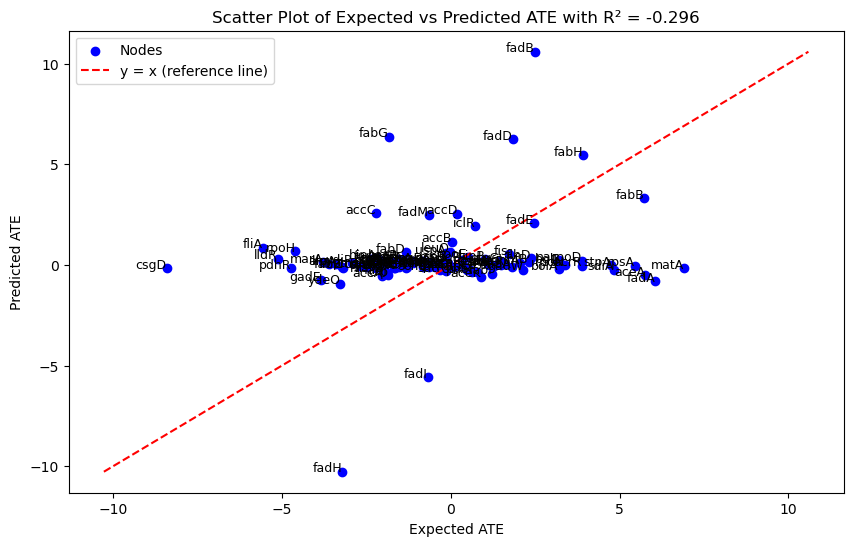

In [41]:


# print(f"expected ATE:{expected_fadr_ATE}")
# print(f"actual ATE:{predicted_fadr_ATE}")


# Extract values in the same order
expected_values = np.array([expected_fadr_ATE[node] for node in expected_fadr_ATE])
predicted_values = np.array([predicted_fadr_ATE[node] for node in predicted_fadr_ATE])

# Calculate R2 value
r2 = r2_score(expected_values, predicted_values)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(expected_values, predicted_values, color="blue", label="Nodes")

# Add node labels
for i, node in enumerate(expected_fadr_ATE.keys()):
    plt.text(expected_values[i], predicted_values[i], node, fontsize=9, ha="right")

# Reference line (y=x)
max_val = max(np.max(expected_values), np.max(predicted_values))
min_val = min(np.min(expected_values), np.min(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")

# Add labels and title
plt.xlabel("Expected ATE")
plt.ylabel("Predicted ATE")
plt.title(f"Scatter Plot of Expected vs Predicted ATE with R² = {r2:.3f}")
plt.legend()

plt.show()